## SECTION 1: SETUP AND INSTALLATION

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import timm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print("All packages installed successfully!")

## SECTION 2: CONFIGURATION & SETUP

In [ ]:
# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   # ← ini yang benar
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cpu':
    print("Running on CPU - Training will be slower. Consider using Google Colab for GPU access.")

# Dataset paths
TRAIN_DIR = 'train'
TEST_DIR = 'test'
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'

# Configuration
CONFIG = {
    'img_size': 224,
    'batch_size': 8,  # Reduced batch size for CPU
    'num_workers': 0,  # Set to 0 for Windows/CPU to avoid multiprocessing issues
    'validation_split': 0.2,
    'num_epochs': 10,
    'learning_rate': 1e-4,
    'num_classes': 5,
}

CLASS_NAMES = ["bakso", "gado_gado", "nasi_goreng", "rendang", "soto_ayam"]

print(f"\nConfiguration:")
print(f"   Image Size: {CONFIG['img_size']}x{CONFIG['img_size']}")
print(f"   Batch Size: {CONFIG['batch_size']}")
print(f"   Epochs: {CONFIG['num_epochs']}")
print(f"   Learning Rate: {CONFIG['learning_rate']}")

## SECTION 3: DATASET & DATALOADER

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.df.iloc[idx]['label']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and split data
train_df = pd.read_csv(TRAIN_CSV)
print(f"Total samples: {len(train_df)}")
print("\nClass distribution:")
print(train_df['label'].value_counts())

train_data, val_data = train_test_split(
    train_df, 
    test_size=CONFIG['validation_split'],
    random_state=42,
    stratify=train_df['label']
)

train_dataset = FoodDataset(train_data, TRAIN_DIR, train_transform)
val_dataset = FoodDataset(val_data, TRAIN_DIR, val_transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=CONFIG['num_workers'],
    pin_memory=False  # Set to False for CPU
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=CONFIG['num_workers'],
    pin_memory=False  # Set to False for CPU
)

print(f"Data loaders created: {len(train_loader)} train batches, {len(val_loader)} val batches")

## SECTION 4: MODEL INITIALIZATION

In [ ]:
# Use smaller variants for CPU or limited resources
if device.type == 'cpu':
    print("\nCPU detected - using smaller model variants for faster training")
    MODEL_CONFIGS = {
        'ViT': 'vit_small_patch16_224',
        'Swin': 'swin_tiny_patch4_window7_224',
        'DeiT': 'deit_small_patch16_224'
    }
else:
    MODEL_CONFIGS = {
        'ViT': 'vit_base_patch16_224',
        'Swin': 'swin_base_patch4_window7_224',
        'DeiT': 'deit_base_patch16_224'
    }

models = {}
model_info = {}

print("\nInitializing Models...")
for name, model_name in MODEL_CONFIGS.items():
    try:
        print(f"\nLoading {name} ({model_name})...")
        model = timm.create_model(model_name, pretrained=True, num_classes=CONFIG['num_classes'])
        model = model.to(device)
        
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        models[name] = model
        model_info[name] = {
            'model_name': model_name,
            'total_params': total_params,
            'trainable_params': trainable_params,
            'model_size_mb': total_params * 4 / (1024**2)
        }
        
        print(f" {name}: {total_params:,} parameters ({model_info[name]['model_size_mb']:.2f} MB)")
    except Exception as e:
        print(f"{name}: Failed to load - {e}")
        print(f"   Trying smaller variant...")
        
        # Fallback to even smaller models
        fallback = {
            'ViT': 'vit_tiny_patch16_224',
            'Swin': 'swin_tiny_patch4_window7_224',
            'DeiT': 'deit_tiny_patch16_224'
        }
        
        try:
            model = timm.create_model(fallback[name], pretrained=True, num_classes=CONFIG['num_classes'])
            model = model.to(device)
            
            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            
            models[name] = model
            model_info[name] = {
                'model_name': fallback[name],
                'total_params': total_params,
                'trainable_params': trainable_params,
                'model_size_mb': total_params * 4 / (1024**2)
            }
            
            print(f"✅ {name} (fallback): {total_params:,} parameters")
        except Exception as e2:
            print(f"{name}: Fallback also failed - {e2}")

if len(models) == 0:
    raise RuntimeError("No models could be loaded! Please check your internet connection or timm installation.")

print(f"\nSuccessfully loaded {len(models)} model(s)")

## SECTION 5: TRAINING FUNCTIONS

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Show progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx+1}/{len(loader)} - Loss: {loss.item():.4f}", end='\r')
    
    return running_loss / len(loader), 100. * correct / total

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / len(loader), 100. * correct / total, all_preds, all_labels

## SECTION 6: TRAINING LOOP

In [ ]:
training_results = {}

print("\nStarting Training...")
for model_name, model in models.items():
    print(f"\n{'='*60}\nTraining {model_name}\n{'='*60}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'])
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    start_time = time.time()
    
    for epoch in range(CONFIG['num_epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pth')
    
    training_time = time.time() - start_time
    training_results[model_name] = {
        'history': history,
        'best_val_acc': best_val_acc,
        'training_time': training_time,
        'final_preds': val_preds,
        'final_labels': val_labels
    }
    
    print(f"Best Val Acc: {best_val_acc:.2f}% | Time: {training_time/60:.2f} min")

## SECTION 7: EVALUATION METRICS

In [ ]:
print("\nCalculating Performance Metrics...")

detailed_metrics = {}

for model_name, model in models.items():
    model.load_state_dict(torch.load(f'best_{model_name.lower()}_model.pth'))
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0) * 100
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0) * 100
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) * 100
    
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    detailed_metrics[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }
    
    print(f"\n{model_name}:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.2f}%")
    print(f"  Recall: {recall:.2f}%")
    print(f"  F1-Score: {f1:.2f}%")

## SECTION 8: INFERENCE TIME MEASUREMENT

In [ ]:
print("\nMeasuring Inference Time...")

inference_times = {}
test_batch = next(iter(val_loader))[0].to(device)
num_iterations = 100

for model_name, model in models.items():
    model.eval()
    
    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(test_batch[:1])
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    # Measure single image inference
    times = []
    with torch.no_grad():
        for _ in range(num_iterations):
            start = time.time()
            _ = model(test_batch[:1])
            if device.type == 'cuda':
                torch.cuda.synchronize()
            times.append((time.time() - start) * 1000)
    
    mean_time = np.mean(times)
    std_time = np.std(times)
    throughput = 1000 / mean_time
    
    inference_times[model_name] = {
        'mean_ms': mean_time,
        'std_ms': std_time,
        'throughput_ips': throughput
    }
    
    print(f"{model_name}: {mean_time:.2f} ± {std_time:.2f} ms ({throughput:.2f} img/s)")

## SECTION 9: VISUALIZATION

In [ ]:
# Training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for model_name, results in training_results.items():
    axes[0,0].plot(results['history']['train_loss'], label=model_name)
    axes[0,1].plot(results['history']['val_loss'], label=model_name)
    axes[1,0].plot(results['history']['train_acc'], label=model_name)
    axes[1,1].plot(results['history']['val_acc'], label=model_name)

axes[0,0].set_title('Training Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].set_title('Validation Loss')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].set_title('Training Accuracy')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].set_title('Validation Accuracy')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300)
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, metrics) in enumerate(detailed_metrics.items()):
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[idx])
    axes[idx].set_title(f'{model_name}\nAccuracy: {metrics["accuracy"]:.2f}%')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300)
plt.show()

## SECTION 10: COMPARISON SUMMARY

✅ All packages installed successfully!
🖥️  Device: cpu
⚠️  Running on CPU - Training will be slower. Consider using Google Colab for GPU access.

⚙️  Configuration:
   Image Size: 224x224
   Batch Size: 8
   Epochs: 10
   Learning Rate: 0.0001
📊 Total samples: 1108

Class distribution:
label
nasi_goreng    234
rendang        227
bakso          220
gado_gado      215
soto_ayam      212
Name: count, dtype: int64
✅ Data loaders created: 111 train batches, 28 val batches

⚠️  CPU detected - using smaller model variants for faster training

🏗️  Initializing Models...

Loading ViT (vit_small_patch16_224)...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

✅ ViT: 21,667,589 parameters (82.66 MB)

Loading Swin (swin_tiny_patch4_window7_224)...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

✅ Swin: 27,523,199 parameters (104.99 MB)

Loading DeiT (deit_small_patch16_224)...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

✅ DeiT: 21,667,589 parameters (82.66 MB)

✅ Successfully loaded 3 model(s)

🚀 Starting Training...

Training ViT
Epoch 1/10 - Train Loss: 0.6331, Train Acc: 76.64% | Val Loss: 0.1418, Val Acc: 94.14%
Epoch 2/10 - Train Loss: 0.1336, Train Acc: 95.49% | Val Loss: 0.3662, Val Acc: 89.64%
Epoch 3/10 - Train Loss: 0.0771, Train Acc: 96.84% | Val Loss: 0.2931, Val Acc: 90.09%
Epoch 4/10 - Train Loss: 0.0699, Train Acc: 97.63% | Val Loss: 0.1007, Val Acc: 97.30%
Epoch 5/10 - Train Loss: 0.0183, Train Acc: 99.21% | Val Loss: 0.0430, Val Acc: 98.65%
Epoch 6/10 - Train Loss: 0.0015, Train Acc: 100.00% | Val Loss: 0.0536, Val Acc: 98.20%
Epoch 7/10 - Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0551, Val Acc: 98.20%
Epoch 8/10 - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0609, Val Acc: 98.65%
Epoch 9/10 - Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0691, Val Acc: 99.10%
Epoch 10/10 - Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0651, Val Acc: 98.65%
✅ Best Val 

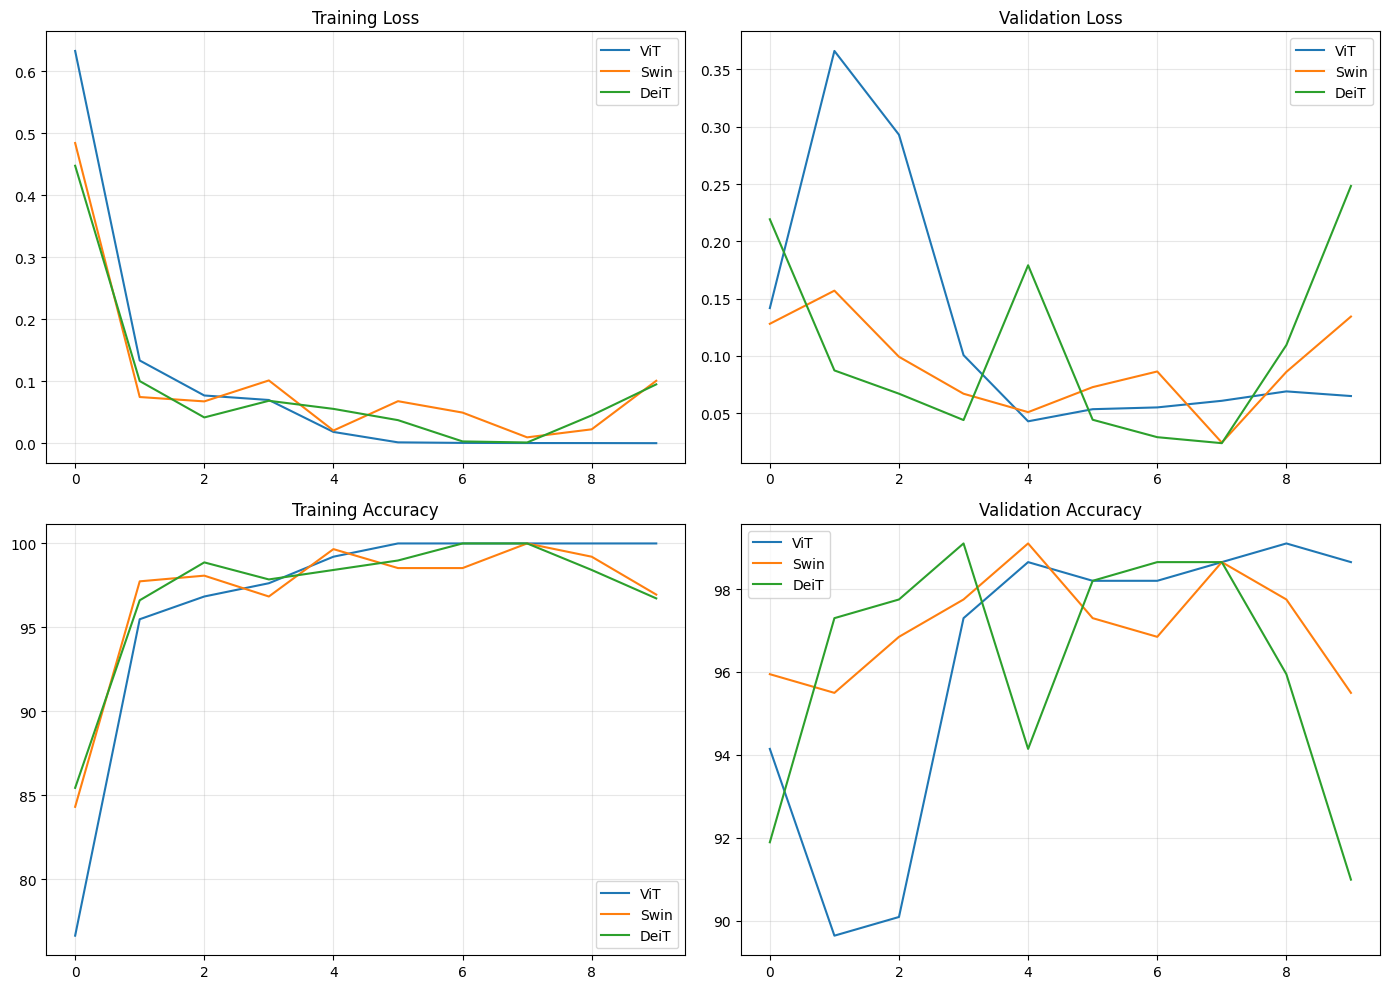

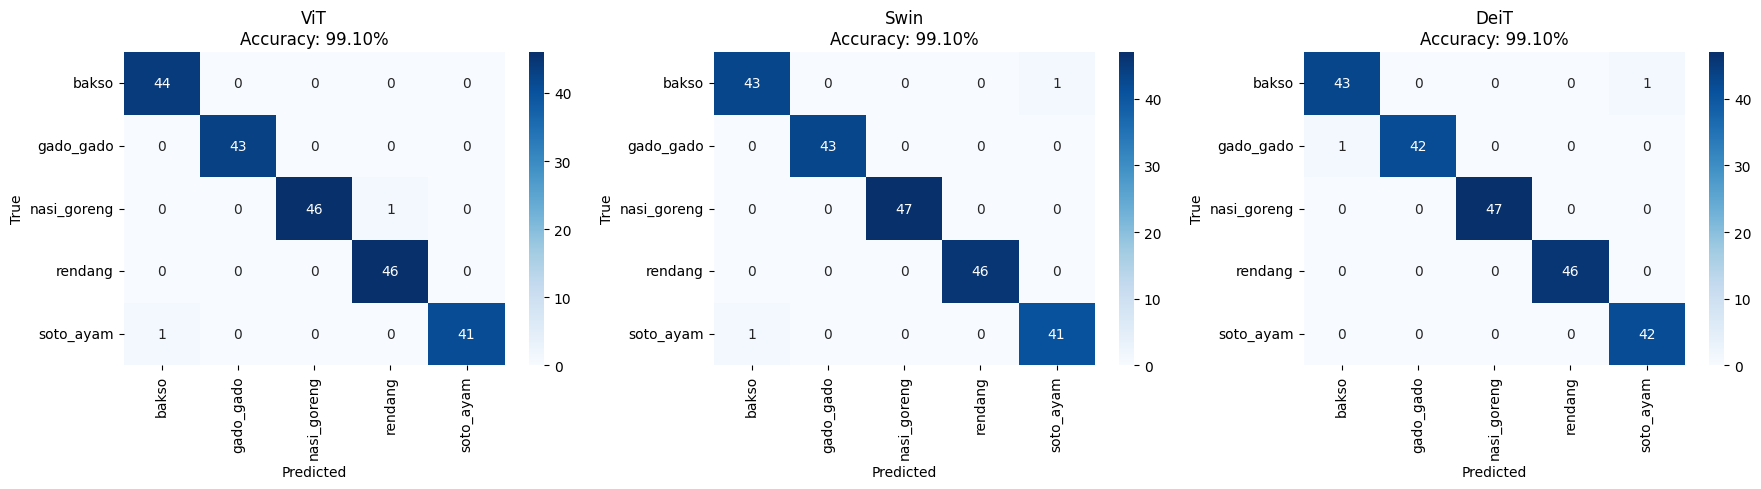


📊 COMPREHENSIVE COMPARISON SUMMARY

Model  Parameters (M)  Size (MB)  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  Inference (ms)  Training Time (min)
  ViT       21.667589  82.655293     99.099099      99.130024   99.098278     99.104210      114.007466            63.391422
 Swin       27.523199 104.992672     99.099099      99.069264   99.069264     99.069264      149.821115            91.011632
 DeiT       21.667589  82.655293     99.099099      99.080338   99.080338     99.074866      114.545028            65.750052

PER-CLASS METRICS

bakso:
  ViT: Precision=97.78%, Recall=100.00%, F1=98.88%
  Swin: Precision=97.73%, Recall=97.73%, F1=97.73%
  DeiT: Precision=97.73%, Recall=97.73%, F1=97.73%

gado_gado:
  ViT: Precision=100.00%, Recall=100.00%, F1=100.00%
  Swin: Precision=100.00%, Recall=100.00%, F1=100.00%
  DeiT: Precision=100.00%, Recall=97.67%, F1=98.82%

nasi_goreng:
  ViT: Precision=100.00%, Recall=97.87%, F1=98.92%
  Swin: Precision=100.00%, Recall=100.00%, F1=1

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON SUMMARY")
print("="*80)

# Create summary table
summary_data = []
for model_name in models.keys():
    summary_data.append({
        'Model': model_name,
        'Parameters (M)': model_info[model_name]['total_params'] / 1e6,
        'Size (MB)': model_info[model_name]['model_size_mb'],
        'Accuracy (%)': detailed_metrics[model_name]['accuracy'],
        'Precision (%)': detailed_metrics[model_name]['precision'],
        'Recall (%)': detailed_metrics[model_name]['recall'],
        'F1-Score (%)': detailed_metrics[model_name]['f1'],
        'Inference (ms)': inference_times[model_name]['mean_ms'],
        'Training Time (min)': training_results[model_name]['training_time'] / 60
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('model_comparison_summary.csv', index=False)

# Per-class metrics
print("\n" + "="*80)
print("PER-CLASS METRICS")
print("="*80)

for i, class_name in enumerate(CLASS_NAMES):
    print(f"\n{class_name}:")
    for model_name in models.keys():
        p = detailed_metrics[model_name]['precision_per_class'][i] * 100
        r = detailed_metrics[model_name]['recall_per_class'][i] * 100
        f = detailed_metrics[model_name]['f1_per_class'][i] * 100
        print(f"  {model_name}: Precision={p:.2f}%, Recall={r:.2f}%, F1={f:.2f}%")

# Classification reports
print("\n" + "="*80)
print("CLASSIFICATION REPORTS")
print("="*80)

for model_name in models.keys():
    print(f"\n{model_name}:")
    print(classification_report(
        detailed_metrics[model_name]['labels'],
        detailed_metrics[model_name]['predictions'],
        target_names=CLASS_NAMES
    ))

print("\n✅ Experiment completed! All results saved.")